<a href="https://colab.research.google.com/github/JoSungHun/Deeplearning/blob/master/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment

* Due date: **2018/04/23 00:00** (will not accept late submission)
* Submittion format: notebook file which can be executed in Colab environment

* We will train CNN using `dogs_vs_cats_subset.zip` distributed in the class.

> ### Prepare the dataset

* Place the unzipped files in some directory on your Colab instance.
* Count the number of JPEG files in `train`, `validation`, and `test` folders.

In [0]:
import keras
import numpy as np

In [0]:
%rm -r '/content/dogs_vs_cats_subset'

rm: cannot remove '/content/dogs_vs_cats_subset': No such file or directory


In [0]:
from google.colab import drive
drive.mount('/content/gdriv')

import zipfile, os, shutil

dataset = '/content/gdriv/My Drive/딥러닝/딥러닝 수업/dogs_vs_cats_subset.zip'
dst_path = '/content/dogs_vs_cats_subset'
dst_file = os.path.join(dst_path, 'dogs_vs_cats_subset.zip')

os.makedirs(dst_path)

shutil.copy(dataset, dst_file)

with zipfile.ZipFile(dst_file, 'r') as file:
  file.extractall(dst_path)
  
train_cats_dir = os.path.join(dst_path, 'subset/train/cats')
train_dogs_dir = os.path.join(dst_path, 'subset/train/dogs')

validation_cats_dir = os.path.join(dst_path, 'subset/validation/cats')
validation_dogs_dir = os.path.join(dst_path, 'subset/validation/dogs')

test_cats_dir = os.path.join(dst_path, 'subset/test/cats')
test_dogs_dir = os.path.join(dst_path, 'subset/test/dogs')

train_dir = os.path.join(dst_path, 'subset/train')
val_dir = os.path.join(dst_path, 'subset/validation')

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

Drive already mounted at /content/gdriv; to attempt to forcibly remount, call drive.mount("/content/gdriv", force_remount=True).
total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


> ### Build the network

* Build a convolutional neural network having the following layers.
  * Assume that the input of size (150, 150) and `relu` activations
  * Preserve spatial resolution of input tensor by padding
  * Layer 1: convolutional layer with kernel size 5, stride 2, 16 filters
  * Layer 2: convolutional layer with kernel size 3, stride 2, 16 filters
  * Layer 3: convolutional layer with kernel size 3, stride 2, 16 filters
  * Layer 4: convolutional layer with kernel size 3, stride 2, 32 filters
  * Layer 5: convolutional layer with kernel size 3, stride 2, 32 filters
  * Layer 6: fully connected layer with 64 hidden nodes
  * Layer 7: (output layer) fully connected layer with **2 output nodes**
  * Others not specified should be chosen yourself.

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(16, (5,5), strides=(2, 2), padding='same', activation='relu', input_shape=(150,150,3)))
model.add(layers.Conv2D(16, (3,3), strides=(2, 2), padding='same', activation='relu'))
model.add(layers.Conv2D(16, (3,3), strides=(2, 2), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3,3), strides=(2, 2), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3,3), strides=(2, 2), padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation ='softmax' ))

Instructions for updating:
Colocations handled automatically by placer.


* Print the summary of model.
* **Explain** how to compute the total number of trainable parameters.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 16)        1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                51264     
__________

###Explain
파라미터의 수는 
Conv2D레이어의 경우 입력채널 * 필터 폭 * 필터 높이 * 출력채널 + 바이어스

Dense 레이어의 경우 이전 노드와 그다음 노드가 모두 연결되어서 이전노드 * 출력 노드 + 바이어스



> ### Preprocess 

  * Currently, the data is stored as JPEG files. So we need the following steps:
    * Read the picture files.
    * Decode the JPEG content to RGB grids of pixels.
    * Convert these into floating-point tensors.
    * Normalize the data to have zero mean and unit variance.
      * Assume that the mean of training data is [123.68, 116.779, 103.939]. Here, each value represents the mean for each channel.
      * Also, we know that the std of training data is [58.40, 57.12, 57.38]. Again, each value represents the std for each channel. 
      * You should normalize the input data using the above statistics, i.e., input[channel] = (input[channel] - mean[channel]) / std[channel].
      * TIP: google "keras imagedatagenerator normalization" and/or refer to Keras documentation.
      * Note that the validation and test data should be normalized using the statistics calculated from the training dataset.
    
  * Make `ImageDataGenerator` instances for the training and validation dataset respectively to obtain batches of preprocessed tensors.
    * Set `batch_size` to 20.


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image



datagen = image.ImageDataGenerator(featurewise_center=True,
                                   featurewise_std_normalization=True)

train_batches = datagen.flow_from_directory(train_dir,
                                      target_size=(150,150),
                                      color_mode='rgb',
                                      class_mode='categorical',
                                      shuffle=True,
                                      batch_size=20)

val_batches = datagen.flow_from_directory(val_dir,
                                      target_size=(150,150),
                                      color_mode='rgb',
                                      class_mode='categorical',
                                      shuffle=True,
                                      batch_size=20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


> ### Train the network

* Train the network for 50 epochs. It may consume some time.

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(
train_batches,
steps_per_epoch = 100,
epochs = 50,
validation_data = val_batches,
validation_steps = 50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
100/100 [==============================] - 11s 113ms/step - loss: 0.6923 - acc: 0.5455 - val_loss: 0.6919 - val_acc: 0.5370
Epoch 2/50
100/100 [==============================] - 8s 84ms/step - loss: 0.6516 - acc: 0.6090 - val_loss: 0.6622 - val_acc: 0.6130
Epoch 3/50
100/100 [==============================] - 8s 85ms/step - loss: 0.6045 - acc: 0.6725 - val_loss: 0.6545 - val_acc: 0.6400
Epoch 4/50
100/100 [==============================] - 9s 86ms/step - loss: 0.5624 - acc: 0.7205 - val_loss: 0.6506 - val_acc: 0.6490
Epoch 5/50
100/100 [==============================] - 10s 96ms/step - loss: 0.5075 - acc: 0.7560 - val_loss: 0.6377 - val_acc: 0.6410
Epoch 6/50
100/100 [==============================] - 8s 84ms/step - loss: 0.4330 - acc: 0.7955 - val_loss: 0.6883 - val_acc: 0.6550
Epoch 7/50
100/100 [==============================] - 8s 84ms/step - loss: 0.3626 - acc: 0.8405 - val_loss: 0.7663 - val_acc: 0.6450
Epoch 8/50
100/100

> ### Plot training and validation accuracy

* Plot training and validation accuracy and discuss their behavior.

In [0]:
model.save('cats_and_dogs_subset_2.h5')

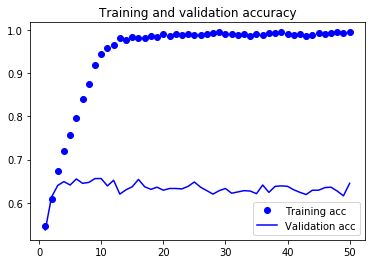

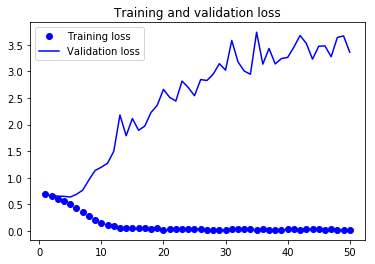

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

###discuss

그래프를 보면 훈련 정확도는 100에 가까워지고 훈련 손실은 지속적으로 감소하지만 검증 정확도와 검증 손실은 일정 에폭 이후로 크게 달라지지 않는것을 볼 수 있다. 대략적으로 모델이 16에폭 정도 이후에 과대적합 되고 있다.